In [7]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time
import scipy
from scipy.spatial import distance_matrix


In [8]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

In [9]:
class OptAiNet():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 Nc:int,
                 chrom_length:int,
                 value_ranges:list,
                 fitness_func, # Function Type,
                 beta=100,
                 clone_threshold = 0.1,
                 supression_threshold=0.2,
                 newcomers_percentage = 0.4,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.value_ranges = np.array(value_ranges)
        self.fitness_func = fitness_func
        self.chrom_length = chrom_length
        self.Nc = Nc
        self.beta = beta
        self.clone_threshold = clone_threshold
        self.supression_threshold = supression_threshold
        self.newcomers_percentage = newcomers_percentage

        self.f_avg_clone_mutated_previous = 0
        self.continue_clone = True

        self.seed = seed    
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose
        np.random.seed(seed=seed)

        # For tests:
        #self.init_pop()
        #self.clone()
        #self.mutation()
        #self.evaluation()
        #self.add_memory_cells()
    
    def init_pop(self):
        self.pop = np.random.rand(self.pop_size, self.chrom_length)
        self.min_mat = self.value_ranges.T[0, :]
        self.max_mat = self.value_ranges.T[1,:]
        self.pop = self.pop * (self.max_mat - self.min_mat) + self.min_mat
        self.f_pop = self.fitness_func(self.pop)
        self.f_pop_clone = self.f_pop.copy()
        self.pop_clone = self.pop.copy()
        #print(self.f_pop)
    
    def clone(self):
        self.pop_clone = np.repeat(self.pop_clone, repeats=self.Nc, axis=0)
        #self.pop_clone = self.pop_clone.reshape((1, self.Nc, -1, self.chrom_length))
        #self.formatted_pop_clone = self.pop_clone.reshape((-1, self.chrom_length))
        self.f_pop_clone = self.fitness_func(self.pop_clone)
        f_max = self.f_pop_clone.max()
        f_min = self.f_pop_clone.min()
        self.f_pop_clone_norm = (self.f_pop_clone - f_min)/ (f_max - f_min)

    def mutation(self):
        self.alpha = (1/self.beta) * np.exp(self.f_pop_clone_norm)
        self.alpha = np.repeat(self.alpha, self.chrom_length)
        self.random_mutation = np.random.normal(0, 1, size=self.pop_clone.shape[0] * self.pop_clone.shape[1])
        self.random_mutation = self.random_mutation.reshape(self.pop_clone.shape[0], self.pop_clone.shape[1])
        self.alpha = self.alpha.reshape(self.random_mutation.shape)

        mask = np.zeros(self.random_mutation.shape[0], dtype=bool)
        mask[::2] = True
        self.random_mutation[mask,:] = 0

        self.pop_clone_mutated = self.pop_clone + self.alpha * self.random_mutation
        # Stops algorithm from violating the delimited search area
        self.repeat_min_mat = np.tile(self.min_mat, (self.pop_clone_mutated.shape[0], 1))
        self.repeat_max_mat = np.tile(self.max_mat, (self.pop_clone_mutated.shape[0], 1))
        self.pop_clone_mutated[self.pop_clone_mutated < self.repeat_min_mat] = self.repeat_min_mat[self.pop_clone_mutated < self.repeat_min_mat]
        self.pop_clone_mutated[self.pop_clone_mutated > self.repeat_max_mat] = self.repeat_max_mat[self.pop_clone_mutated > self.repeat_max_mat]

        self.f_pop_clone_mutated = self.fitness_func(self.pop_clone_mutated)
        self.pop_clone = self.pop_clone_mutated
        self.f_pop_clone = self.f_pop_clone_mutated

    
    def evaluation(self):
        self.f_avg_clone_mutated = self.f_pop_clone_mutated.mean()
        if np.abs(self.f_avg_clone_mutated - self.f_avg_clone_mutated_previous) < self.clone_threshold:
            self.continue_clone = False
        else:
            self.continue_clone = True
        self.f_avg_clone_mutated_previous = self.f_avg_clone_mutated
    
    def add_memory_cells(self):
        # Calculates affinity (euclidian distance between all points)
        distances = distance_matrix(self.pop_clone, self.pop_clone)
        # Replicates the fitness results into a matrix pop_clone_size x pop_clone_size
        f_pop_clone_matrix = np.tile(self.f_pop_clone, (distances.shape[0], 1))        
        # Uses a mask to find which values are lower than the threshold
        masked_f = f_pop_clone_matrix * (distances<self.supression_threshold)
        best_indices = np.where(masked_f == masked_f.max(axis=1).T)[1]
        best_indices = np.unique(best_indices)
        self.memory_cells = self.pop_clone[best_indices]

        # Does the same thing in pop to check whether the memory cell is necessary
        #
        #self.pop = np.append(self.pop, self.memory_cells, axis=0)
        self.pop = self.memory_cells
        self.pop_clone = self.pop.copy()


    def add_newcomers(self):
        n_new_ind = int(len(self.pop) * self.newcomers_percentage)
        if n_new_ind == 0:
            n_new_ind = 1
        newcomers = np.random.rand(n_new_ind, self.chrom_length)
        newcomers = newcomers * (self.max_mat - self.min_mat) + self.min_mat
        self.best_ind = self.pop.copy()
        self.pop = np.append(self.pop, newcomers, axis=0)
        self.pop_clone = self.pop.copy()
        self.f_pop = self.fitness_func(self.pop)
        return
    
    def callback(self):
        max_val = np.max(self.f_pop)
        mean_val = np.mean(self.f_pop)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")

    def fit(self):
        start_time = time.time()
        self.init_pop()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            while self.continue_clone:
                self.clone()
                self.mutation()
                self.evaluation()
            self.continue_clone = True
            self.add_memory_cells()
            self.add_newcomers()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.best_ind
    
    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()




opt_ai_net = OptAiNet( 
                num_epochs=10,
                pop_size=20,
                Nc=10,
                chrom_length=2,
                clone_threshold=0.2,
                supression_threshold=0.2,
                newcomers_percentage=0.4,
                beta=10,
                value_ranges=[(-10,10), (-10,10)],
                fitness_func=schaffer_function
            )

best_solutions = opt_ai_net.fit()
opt_ai_net.plot()

 50%|█████     | 5/10 [01:32<02:29, 29.81s/it]

: 

: 

Text(0.5, 0, 'z')

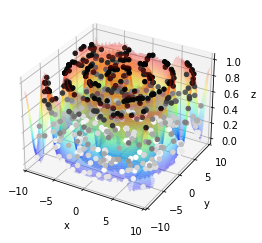

In [ ]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

x_data = best_solutions[:, 0]
y_data = best_solutions[:, 1]
z_data = schaffer_function_plot(x_data, y_data)

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.2)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)
ax.set_xlim3d(-10,10)
ax.set_ylim3d(-10,10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
